In [1]:
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='microsoft/deberta-base'

In [3]:
results = {'acc':[],
           'f1':[],
           'r':[]}

In [4]:
g = 2
lr = 1.0e-5
wd = 0.01
alphas = [8, 16]
ranks = [8, 16]
lora_dropout = 0.0


for a,r in zip(alphas, ranks):
    print(f'Grid search {model_checkpoint}, learning rate {lr} focal loss, gamma: {g} wd: {wd}, Lora alpha {a}, rank {r}')
    data = ClimateDataset(model_to_train=2,model_checkpoint=model_checkpoint,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,
                            num_labels=data.num_labels,
                            lora=True,
                            r=r,
                            alpha=a,
                            dropout=lora_dropout)
    trainer = Engine(epochs=20,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    acc, f1 = trainer.run(lr=lr,
                          wd=wd,
                          train_dataloader=data.train_dataloader,
                          eval_dataloader=data.eval_dataloader,
                          test_dataloader=data.test_dataloader,
                          focalloss=True,
                          accumulation_steps=2,
                          gamma=g,
                          early_stop=3)
    results['acc'].append(acc)
    results['f1'].append(f1)
    results['r'].append(r)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, acc, f1

Grid search microsoft/deberta-base, learning rate 1e-05 focal loss, gamma: 2 wd: 0.01, Lora alpha 8, rank 8


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 20: Train Loss:	0.7428	Val Loss:	1.0986	Accuracy:	0.3025	F1:	0.1548
2 / 20: Train Loss:	0.7478	Val Loss:	1.0984	Accuracy:	0.3025	F1:	0.1548
3 / 20: Train Loss:	0.7417	Val Loss:	1.0981	Accuracy:	0.3025	F1:	0.1548
4 / 20: Train Loss:	0.7456	Val Loss:	1.0979	Accuracy:	0.3025	F1:	0.1548
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.00      0.00      0.00        38
oversimplification       0.30      1.00      0.46        36
slothful induction       0.00      0.00      0.00        45

          accuracy                           0.30       119
         macro avg       0.10      0.33      0.15       119
      weighted avg       0.09      0.30      0.14       119

test results:
                    precision    recall  f1-score   support

 misrepresentation       0.00      0.00      0.00        22
oversimplification       0.30      1.00      0.46        20
slothf

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 20: Train Loss:	0.7428	Val Loss:	1.0986	Accuracy:	0.3025	F1:	0.1548
2 / 20: Train Loss:	0.7477	Val Loss:	1.0984	Accuracy:	0.3025	F1:	0.1548
3 / 20: Train Loss:	0.7417	Val Loss:	1.0981	Accuracy:	0.3025	F1:	0.1548
4 / 20: Train Loss:	0.7456	Val Loss:	1.0979	Accuracy:	0.3025	F1:	0.1548
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.00      0.00      0.00        38
oversimplification       0.30      1.00      0.46        36
slothful induction       0.00      0.00      0.00        45

          accuracy                           0.30       119
         macro avg       0.10      0.33      0.15       119
      weighted avg       0.09      0.30      0.14       119

test results:
                    precision    recall  f1-score   support

 misrepresentation       0.00      0.00      0.00        22
oversimplification       0.30      1.00      0.46        20
slothf

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

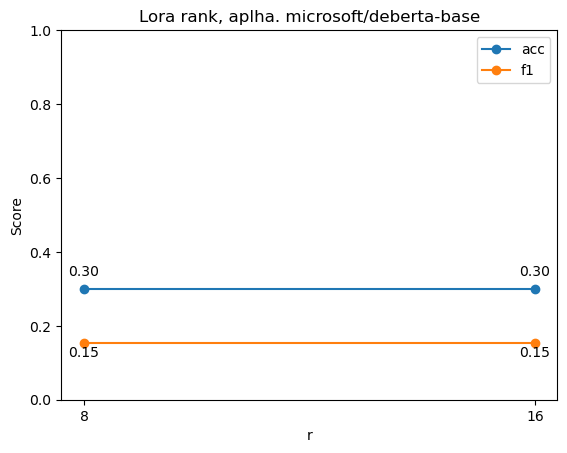

In [6]:
def plot_grid_search(df, title, column):

    # Create the plot
    ax = df.plot(x=column, y=['acc', 'f1'], marker='o', linestyle='-')

    # Set y-axis range between 0 and 1
    plt.ylim(0, 1)

    # Annotate points with F1 scores
    for i, row in df.iterrows(): 
        ax.annotate(f'{row["f1"]:.2f}', (row[column], row["f1"]), textcoords='offset points', xytext=(0, -10), ha='center')

    # Annotate points with Acc scores
    for i, row in df.iterrows():
        ax.annotate(f'{row["acc"]:.2f}', (row[column], row["acc"]), textcoords='offset points', xytext=(0, 10), ha='center')
    
    # 
    plt.xticks(df[column], [val for val in df[column]], ha='center')
    # plt.xscale('log')
    plt.minorticks_off()

    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Score')
    plt.show()

plot_grid_search(pd.DataFrame(results), f'Lora rank, aplha. {model_checkpoint}', 'r')